<a href="https://colab.research.google.com/github/Yakunat/R-u-ready/blob/main/DataminingAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 15:52:09 2023

@author: yakunat
"""

# -*- coding: utf-8 -*-



'\nCreated on Tue Mar  7 15:52:09 2023\n\n@author: yakunat\n'

# Assessment 1: Life Insurance Data

First, we import the necessary libraries and the dataset.

In [2]:
# Import Libraries and Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score



data = pd.read_csv("sales_data.csv") 
data = pd.DataFrame(data)

## Data Exploration

*   Noticed that the column titles are lower case, switched to title case
*   Viewing data types and a glimpse of the data



In [3]:
# Data Exploration
data.head()


,flag,gender,education,house_val,age,online,marriage,child,occupation,mortgage,house_owner,region,fam_income
0,Y,M,4. Grad,756460,1_Unk,N,NaN,U,Professional,1Low,NaN,Midwest,L
1,N,F,3. Bach,213171,7_>65,N,NaN,U,Professional,1Low,Owner,Northeast,G
2,N,M,2. Some College,111147,2_<=25,Y,NaN,Y,Professional,1Low,Owner,Midwest,J
3,Y,M,2. Some College,354151,2_<=25,Y,Single,U,Sales/Service,1Low,NaN,West,L
4,Y,F,2. Some College,117087,1_Unk,Y,Married,Y,Sales/Service,1Low,NaN,South,H


In [4]:
data.columns = data.columns.str.title() #change all column names to Title Case
data.dtypes #View data types

Flag           object
Gender         object
Education      object
House_Val       int64
Age            object
Online         object
Marriage       object
Child          object
Occupation     object
Mortgage       object
House_Owner    object
Region         object
Fam_Income     object
dtype: object

In [5]:
#There are 2 data types - object and number, so describe/summarise both below
desc_data_object=data.describe(include=['object']) #Describe Object datatype
desc_data_object


,Flag,Gender,Education,Age,Online,Marriage,Child,Occupation,Mortgage,House_Owner,Region,Fam_Income
count,40000,40000,39259,40000,40000,25973,40000,40000,40000,36623,40000,40000
unique,2,3,5,7,2,2,4,6,3,2,5,13
top,Y,M,2. Some College,5_<=55,Y,Married,Y,Professional,1Low,Owner,South,E
freq,20000,22019,11400,8103,27319,20891,18012,14936,29848,29232,15676,8432


Observations:
*  'Education', 'Marriage', and 'House Owner' columns have less than the expected number of entries, so there are rows with NAs in them that need to be addressed.
*  The 'Child' column has one more unique entry than expected
*  'Education', 'Age', and 'Mortgage' column have a mix of numbers and letters than can be reduced to just numbers
*  The output variable 'Flag' is equally distributed and since it is a Yes/No entry, it can be converted to binary. 'Online'can also be converted to binary.
*  'Fam_Income', 'Mortgage', 'Age' and 'Education' are categorical variables but they can be ranked so they may be converted to numbers arranged in increasing value

*...Now moving on to the one continuous variable = House Value*

In [6]:
desc_data_number=data.describe(include=['number']) #Describe Number datatype
desc_data_number

,House_Val
count,4.000000e+04
mean,3.072138e+05
std,4.222146e+05
min,0.000000e+00
25%,8.065725e+04
50%,2.148720e+05
75%,3.937620e+05
max,9.999999e+06


Observations:

Everything seems okay except the maximum value which is WAY bigger than the mean by an order of magnitude which will skew any analysis done on with it. There are also zero values there which could be problematic.

*...Next is Data Cleaning*

## Data Cleaning

In [7]:
### ---- Data Cleaning -----###

#Replace 0 value in Children column with N

data['Child'].unique()



array(['U', 'Y', 'N', '0'], dtype=object)

In [8]:
# Zero children means no children so replacing 0's with N
data['Child']=data['Child'].replace("0", "N")

In [9]:
##  Data Cleaning - Handling NAs

# Option 1 - Drop All rows that have one NA entry and save as "clean data"
clean_data = data.dropna()
#This removes over 15,000 rows & skews distribution of the target variable- not ideal

In [10]:
# Option 2 - Replace all NAs with 'unknown'as a category
data['Gender']= data['Gender'].fillna('U')
data['Marriage']= data['Marriage'].fillna('Unknown')
data['House_Owner']= data['House_Owner'].fillna('Unknown') 

Going to treat the Education column differently . The number of missing entries is less than 750 which is below 2% of the total number of entries. We will assign them to the most frequent category which is 2 (see: *desc_data_object*). Because it is a small percentage, it should not affect the distribution of the data significantly.

In [11]:
# Option 2B - The Education column NA replaced with most frequent category
data['Education']= data['Education'].fillna("2. Some College") 


In [12]:
data.describe(include=['object']) #Notice the entries are now complete 40,000


,Flag,Gender,Education,Age,Online,Marriage,Child,Occupation,Mortgage,House_Owner,Region,Fam_Income
count,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000
unique,2,3,5,7,2,3,3,6,3,3,5,13
top,Y,M,2. Some College,5_<=55,Y,Married,Y,Professional,1Low,Owner,South,E
freq,20000,22019,12141,8103,27319,20891,18012,14936,29848,29232,15676,8432


Now we want to keep only the 1st character of the Education, Age and Mortgage columns so that we just have numbers representing the entries instead of a mix of numbers and characters.

In [13]:
##  Data Cleaning - Ordering and cleaning categorical data

#Clean the age, mortgage and education entries to retain only numbers
data['Education'] = data.Education.str[:1]
data['Mortgage'] = data.Mortgage.str[:1]
data['Age']=data.Age.str[:1]


Next, in Flag and Online columns, we can change the binary Y/N responses to 1/0 respectively.
Also, Family income is ordered so we can change those letters U-A to numbers 0-12 instead (*In order of increasing value*).

In [14]:
data['Flag'] = data['Flag'].map({'Y': 1, 'N': 0}) #Y/N to binary
data['Online'] = data['Online'].map({'Y': 1, 'N': 0}) #Y/N to binary
#Ranking the Fam_Income column letters
data['Fam_Income']=data['Fam_Income'].map({'U':0,'L':1,'K':2,'J':3,'I':4,'H':5,'G':6,'F':7,'E':8,'D':9,'C':10,'B':11,'A':12})

data.head()

,Flag,Gender,Education,House_Val,Age,Online,Marriage,Child,Occupation,Mortgage,House_Owner,Region,Fam_Income
0,1,M,4,756460,1,0,Unknown,U,Professional,1,Unknown,Midwest,1
1,0,F,3,213171,7,0,Unknown,U,Professional,1,Owner,Northeast,6
2,0,M,2,111147,2,1,Unknown,Y,Professional,1,Owner,Midwest,3
3,1,M,2,354151,2,1,Single,U,Sales/Service,1,Unknown,West,1
4,1,F,2,117087,1,1,Married,Y,Sales/Service,1,Unknown,South,5


There are too many zero values in the House Val column.

In [15]:
data['House_Val'].value_counts()[0]

7696

We will replace them with the average house value for the region. So first we get the average house values grouped by region.

In [16]:
grouped_house_region = data.groupby(['Region'])[['House_Val']].mean() #mean house value per region
grouped_house_region


,House_Val
Region,
Midwest,195811.043666
Northeast,341896.137022
Rest,439255.269388
South,277596.218104
West,431424.201261


In [17]:
data['House_Val'] = np.where((data['House_Val'] <= 0) & (data['Region'] == 'Midwest'), 195811, data['House_Val'])


In [18]:
data['House_Val'] = np.where((data['House_Val'] <= 0) & (data['Region'] == 'Northeast'), 341896, data['House_Val'])


In [19]:
data['House_Val'] = np.where((data['House_Val'] <= 0) & (data['Region'] == 'Rest'), 439255, data['House_Val'])


In [20]:
data['House_Val'] = np.where((data['House_Val'] <= 0) & (data['Region'] == 'South'), 277596, data['House_Val'])


In [21]:
data['House_Val'] = np.where((data['House_Val'] <= 0) & (data['Region'] == 'West'), 431424, data['House_Val'])

Quick check if it was successful? Yes, the minimum value in the House Val column is no longer zero.

In [22]:
data.describe(include=['number'])

,Flag,House_Val,Online,Fam_Income
count,40000.000000,4.000000e+04,40000.000000,40000.000000
mean,0.500000,3.659208e+05,0.682975,7.173825
std,0.500006,3.975029e+05,0.465323,2.733212
min,0.000000,5.000000e+03,0.000000,0.000000
25%,0.000000,1.855180e+05,0.000000,6.000000
50%,0.500000,2.775960e+05,1.000000,8.000000
75%,1.000000,4.314240e+05,1.000000,9.000000
max,1.000000,9.999999e+06,1.000000,12.000000


## Data Visualisation

***First Hypothesis:***

The older people get, the more likely they are to buy life insurance as they are more likely to have possessions and plans for what happens when they are either unable to work or are no longer present for their loved ones.

First, a quick view of the age distribution.

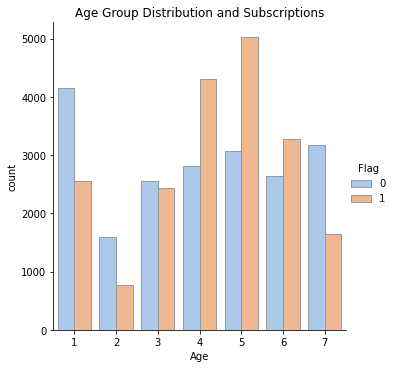

In [23]:
# Age distribution and Subscription Status
import seaborn as sns

sns.catplot(
    data=data, x="Age", hue="Flag", kind="count",
    palette="pastel", edgecolor=".6", order=['1','2','3','4','5','6','7'],
).set(title="Age Group Distribution and Subscriptions")

Graph above shows that generally as people get older they tend to sign up more for life insurance. The only exception to this trend is the Unknown Age group and the elderly over 65 age group. The first guess is this might be an education issue. The more educated one is, the more likely they are to use insurance and other banking services as a whole. The next two graph explore the education distribtion between the general population and the outlier group (Labelled age_flag_mismatch)


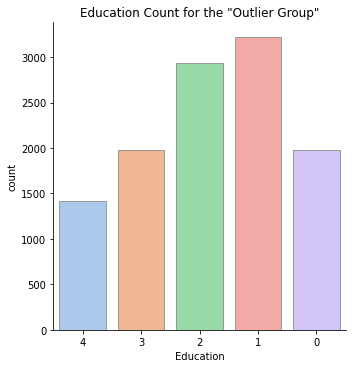

In [24]:
#Filtering the target group
age_flag_mismatch = data[(data['Age'] == "7") | (data['Age']=="1")] 

#Plot their education distribution
sns.catplot(
    data=age_flag_mismatch, x="Education", kind="count",
    palette="pastel", edgecolor=".6",
).set(title='Education Count for the "Outlier Group"')

Compare them with the education of the general population.

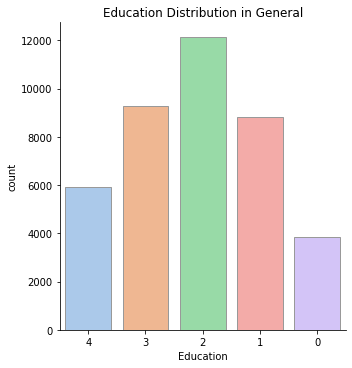

In [25]:
sns.catplot(
    data=data, x="Education", kind="count",
    palette="pastel", edgecolor=".6",
).set(title="Education Distribution in General")

So from comparing the two distributions, we can see than indeed that target group is less educated when compared to the rest of the population. 

Therefore, ***age*** and ***education*** are very likely to be significant predictors of subscription. So let's explore the relationship between Education and Insurance package subscriptions.

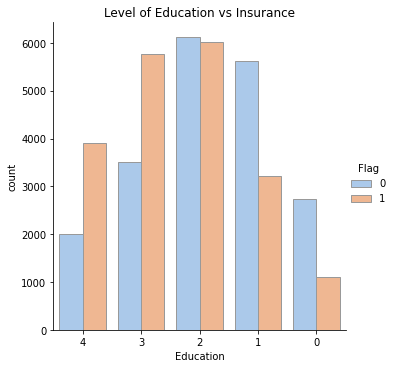

In [26]:
sns.catplot(
    data=data, x="Education", hue="Flag", kind="count",
    palette="pastel", edgecolor=".6",
).set(title="Level of Education vs Insurance")

The hypothesis is confirmed. Insurance subscriptions clearly increase with level of education.

***Second Hypothesis:***

The wealthier you are, the more likely you are to pay for insurance.

Two indicators of disposable income are mortgage and house value so they are compared below.

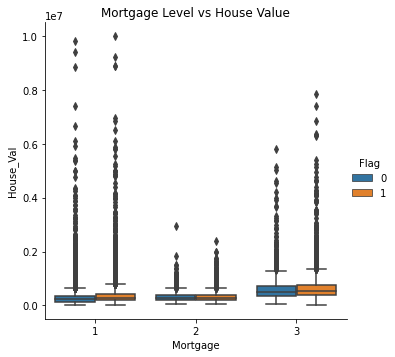

In [27]:
# Mortgage vs House Value

sns.catplot(data=data, x="Mortgage", y="House_Val", hue="Flag", kind="box").set(title='Mortgage Level vs House Value')

The graph indicates two relationships at a glance:


*   Mortgage Level is correlated with mean house value - the higher the value of your home, the higher the level of your mortgage. This makes sense.
*   Within a Mortgage Level class, those with slightly higher value homes are more likely to buy the insurance plan.

Also, the long tail of outliers (very expensive house values) especially in level 1 did not completely distort the distribution enough to make the distinction between Mortgage Levels unnoticeable.

To confirm, we can check house value versus subscriptions alone. This is done below.

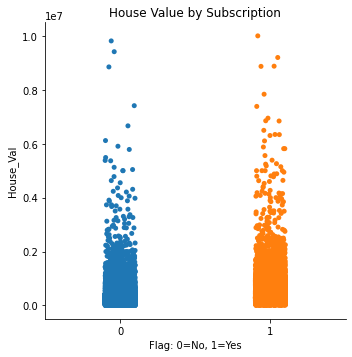

In [28]:
sns.catplot(data=data, x="Flag", y="House_Val").set(title="House Value by Subscription", xlabel="Flag: 0=No, 1=Yes")

There seems to be a clear correlation between the level of family income and subscriptions. The higher the income level, the lower the acceptance ratio for life insurance. It may be theorised that those higher classes already have a life insurance package or a sufficiently better substitute.

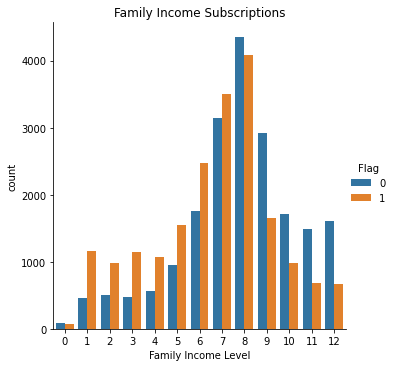

In [29]:
grouped_income = data.groupby(['Fam_Income','Flag'])[['Gender']].count()
grouped_income
sns.catplot(data=data, x="Fam_Income", hue="Flag", kind="count").set(title='Family Income Subscriptions', xlabel="Family Income Level")

***Third Hypothesis:***

People with children are more likely to take a life insurance policy. Children are more often the ones in need of support when an adult passes or is incapacitated.

In [30]:
!pip install squarify
import squarify

#Table showing Flag by Child status count  
# Note: Gender is irrelevant, it could be any other column name there

grouped_child = data.groupby(['Child','Flag'])[['Gender']].count()
grouped_child 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Gender
Child Flag        
N     0       7249
      1       6211
U     0       4206
      1       4322
Y     0       8545
      1       9467

[Text(0.5, 1.0, '(Child,Flag) Treemap')]

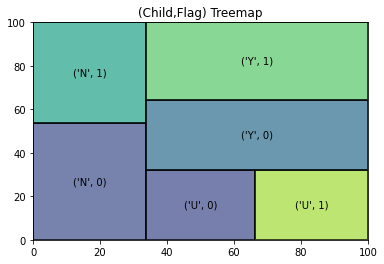

In [31]:
squarify.plot(sizes=grouped_child.values, label=grouped_child.index, alpha=0.7, 
              edgecolor="black", linewidth=2).set(title="(Child,Flag) Treemap")

The treemap and table above show that there is no strong correlation between having children and signing up for a life insurance plan. There are more customers with children than without and yet Y/N ratio among them is not very high. Childless customers are definitely less likely to subscribe but its not a strong relationship.

***Fourth Hypothesis:***

Because life insurance is often a lengthy process, customers may be less likely to book this online.

In [32]:
grouped_online = data.groupby(['Online','Flag'])[['Gender']].count()
grouped_online

Gender
Online Flag        
0      0       8332
       1       4349
1      0      11668
       1      15651

*Hypothesis disproved*. Online is a strong predictor of signup rates. As seen below, the biggest area of the treemap is the (1,1) which mean Online and Yes to the insurance package.

[Text(0.5, 1.0, '(Online,Flag) Treemap')]

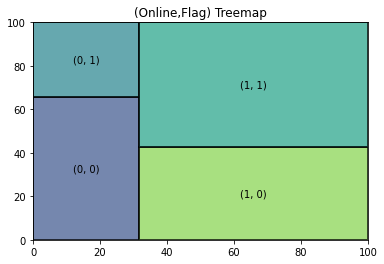

In [33]:
squarify.plot(sizes=grouped_online.values, label=grouped_online.index, alpha=0.7, 
              edgecolor="black", linewidth=2).set(title="(Online,Flag) Treemap")

## Preparing for Classification
### Dummy variables
Some of these categorical variables cannot be changed to numbers directly but we wish to still apply them to the training data so it is best to involve dummy variables. For example, in Region we create dummy variables - columns for each unique value of region. 

But to avoid the dummy variable trap which leads to multicollinearity, we drop one column. In this case, the most obvious option is 'Rest'.

In [34]:
dummy_region = pd.get_dummies(data['Region']).drop(columns=['Rest']) 
dummy_region


,Midwest,Northeast,South,West
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,0,0,0,1
4,0,0,1,0
...,...,...,...,...
39995,0,0,1,0
39996,0,0,1,0
39997,1,0,0,0
39998,0,0,0,1


In [35]:
# Do the same for Married, House Owner, Child and drop the unknowns
dummy_married = pd.get_dummies(data['Marriage']).drop(columns=['Unknown']) 
dummy_houseowner = pd.get_dummies(data['House_Owner']).drop(columns=['Unknown']) 
dummy_child = pd.get_dummies(data['Child']).drop(columns=['U'])
dummy_gender = pd.get_dummies(data['Gender']).drop(columns=['U']) 
#For Occupation, we can drop Others
dummy_occupation=pd.get_dummies(data['Occupation']).drop(columns=['Others'])

In [36]:
new_data = pd.concat([data, dummy_region,dummy_married,dummy_houseowner,dummy_child,dummy_occupation, dummy_gender],axis=1)
new_data.head()

,Flag,Gender,Education,House_Val,Age,Online,Marriage,Child,Occupation,Mortgage,...,Renter,N,Y,Blue Collar,Farm,Professional,Retired,Sales/Service,F,M
0,1,M,4,756460,1,0,Unknown,U,Professional,1,...,0,0,0,0,0,1,0,0,0,1
1,0,F,3,213171,7,0,Unknown,U,Professional,1,...,0,0,0,0,0,1,0,0,1,0
2,0,M,2,111147,2,1,Unknown,Y,Professional,1,...,0,0,1,0,0,1,0,0,0,1
3,1,M,2,354151,2,1,Single,U,Sales/Service,1,...,0,0,0,0,0,0,0,1,0,1
4,1,F,2,117087,1,1,Married,Y,Sales/Service,1,...,0,0,1,0,0,0,0,1,1,0


In [37]:
#First rename child N Y columns for clarity
new_data=new_data.rename(columns={"N": "Child_N", "Y": "Child_Y", "F":"Gender_F", "M":"Gender_M"})


In [38]:
#Now to drop the columns we have duplicated as dummies
new_data=new_data.drop(columns = ['Marriage','Region','House_Owner','Child','Occupation', 'Gender'])

# Classification


In [40]:
new_data.columns.values.tolist()

['Flag',
 'Education',
 'House_Val',
 'Age',
 'Online',
 'Mortgage',
 'Fam_Income',
 'Midwest',
 'Northeast',
 'South',
 'West',
 'Married',
 'Single',
 'Owner',
 'Renter',
 'Child_N',
 'Child_Y',
 'Blue Collar',
 'Farm',
 'Professional',
 'Retired',
 'Sales/Service',
 'Gender_F',
 'Gender_M']

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data[['Education',
 'House_Val',
 'Age',
 'Online',
 'Mortgage',
 'Fam_Income',
 'Midwest',
 'Northeast',
 'South',
 'West',
 'Married',
 'Single',
 'Owner',
 'Renter',
 'Child_N',
 'Child_Y',
 'Blue Collar',
 'Farm',
 'Professional',
 'Retired',
 'Sales/Service',
 'Gender_F',
 'Gender_M']], new_data['Flag'], test_size=0.3, random_state=40381881)

In [42]:
lr = LogisticRegression(multi_class='auto',solver='liblinear')
model = lr.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print ("Accuracy is {}".format(accuracy))


Accuracy is 0.5005833333333334


In [43]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
model_random = clf.fit(X_train, y_train)

accuracy = model_random.score(X_test, y_test)
print ("Accuracy is {}".format(accuracy))

Accuracy is 0.63625


In [44]:
# import the metrics class (From DataCamp)
from sklearn import metrics

y_pred = clf.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
conf_matrix

array([[4174, 1819],
       [2546, 3461]])

In [45]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5993
           1       0.50      1.00      0.67      6007

    accuracy                           0.50     12000
   macro avg       0.25      0.50      0.33     12000
weighted avg       0.25      0.50      0.33     12000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Option 2 is to run all these models at once in order to make them easy to compare. Output is a matrix of accuracy mean and standard deviation for each type of classification. Reference [Link](https://www.kaggle.com/code/djonafegnem/98-accuracy-logistic-regression)

In [47]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))


In [49]:
num_folds = 10
results = []
names = []
print('Mean and Standard Deviation accuracy with 10 folds')
for name, model in models:
    kfold = KFold(n_splits=100)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('{}: {} ({})'.format(name, cv_results.mean(), cv_results.std()))

Mean and Standard Deviation accuracy with 10 folds
LR: 0.4997499999999999 (0.0321993749147085)
KNN: 0.5802857142857143 (0.026951770984179745)
CART: 0.6017857142857143 (0.033656806328659555)
NB: 0.5480357142857144 (0.03032298498445275)
